# **Optimizing AUPRC Loss on imbalanced dataset**

**Author**: Gang Li  
**Edited by**: Zhuoning Yuan

**Introduction**

In this tutorial, you will learn how to quickly train a Resnet18 model by optimizing **AUPRC** loss with **SOAP** optimizer [[ref]](https://arxiv.org/abs/2104.08736) on a binary image classification task with CIFAR-10 dataset. After completion of this tutorial, you should be able to use LibAUC to train your own models on your own datasets.

 
**Useful Resources**:
* Website: https://libauc.org
* Github: https://github.com/Optimization-AI/LibAUC

**Reference**:  

If you find this tutorial helpful,  please acknowledge our library and cite the following paper:
<pre>
@article{qi2021stochastic,
  title={Stochastic Optimization of Areas Under Precision-Recall Curves with Provable Convergence},
  author={Qi, Qi and Luo, Youzhi and Xu, Zhao and Ji, Shuiwang and Yang, Tianbao},
  journal={Advances in Neural Information Processing Systems},
  volume={34},
  year={2021}
}
</pre>

# **Installing LibAUC**
Let's start with install our library here. In this tutorial, we will use version `1.2.0`.

In [1]:
!pip install libauc==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 73 kB 1.0 MB/s 


# **Importing LibAUC**

Import required packages to use

In [2]:
from libauc.losses import APLoss
from libauc.optimizers import SOAP
from libauc.models import resnet18 as ResNet18
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_prc_score

import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import torch
from PIL import Image

# **Configurations**

**Reproducibility**

The following function `set_all_seeds` limits the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [3]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# **Loading datasets**

In this step, , we will use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) as benchmark dataset. Before importing data to `dataloader`, we construct imbalanced version for CIFAR10 by `ImbalanceDataGenerator`. Specifically, it first randomly splits the training data by class ID (e.g., 10 classes) into two even portions as the positive and negative classes, and then it randomly removes some samples from the positive class to make
it imbalanced. We keep the testing set untouched. We refer `imratio` to the ratio of number of positive examples to number of all examples. 

In [4]:
train_data, train_targets = CIFAR10(root='./data', train=True)
test_data, test_targets  = CIFAR10(root='./data', train=False)

imratio = 0.02
generator = ImbalancedDataGenerator(verbose=True, random_seed=2022)
(train_images, train_labels) = generator.transform(train_data, train_targets, imratio=imratio)
(test_images, test_labels) = generator.transform(test_data, test_targets, imratio=0.5) 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
#SAMPLES: [25510], POS:NEG: [510 : 25000], POS RATIO: 0.0200
#SAMPLES: [10000], POS:NEG: [5000 : 5000], POS RATIO: 0.5000


Now that we defined the data input pipeline such as data augmentations. In this tutorials, we use `RandomCrop`, `RandomHorizontalFlip`.

In [5]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
        self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
        
        
        # for loss function
        self.pos_indices = np.flatnonzero(targets==1)
        self.pos_index_map = {}
        for i, idx in enumerate(self.pos_indices):
            self.pos_index_map[idx] = i

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
           idx = self.pos_index_map[idx] if idx in self.pos_indices else -1
           image = self.transform_train(image)
        else:
           image = self.transform_test(image)
        return idx, image, target 

We define `dataset`, `DualSampler` and `dataloader` here. By default, we use `batch_size` 64 and we oversample the minority class with `pos:neg=1:1` by setting `sampling_rate=0.5`.

In [6]:
batch_size = 64
sampling_rate = 0.5

trainSet = ImageDataset(train_images, train_labels)
trainSet_eval = ImageDataset(train_images, train_labels,mode='test')
testSet = ImageDataset(test_images, test_labels, mode='test')

sampler = DualSampler(trainSet, batch_size, sampling_rate=sampling_rate)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batch_size, sampler=sampler, num_workers=2)
trainloader_eval = torch.utils.data.DataLoader(trainSet_eval, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testSet, batch_size=batch_size, shuffle=False, num_workers=2)

# **Loss and Optimizer**

In this section, we will introduce AUPRC optimization algorithm and how to use `APLoss` loss and `SOAP` optimizer .  
### **AP Loss** 
AUPRC is an average of the precision weighted by the probability of a given threshold. We consider to use AP to approximate AUPRC, which is given by

\begin{align}
    \text{AP}&=\frac{1}{n_{+}} \sum\limits_{i=1}^n{\mathbf{I}}(y_i=1) \frac{\sum\limits_{s=1}^n{\mathbf{I}}(y_s=1){\mathbf{I}}(f(\mathbf{x}_s) \geq f(\mathbf{x}_i))}{\sum\limits_{s=1}^n {\mathbf{I}}(f(\mathbf{x}_s)\geq f(\mathbf{x}_i))}.
\end{align} 

we consider $\ell(\mathbf{w}; \mathbf{x}_s, \mathbf{x}_i)$ as a surrogate function of the non-continuous indicator function $\mathbf{I}(f(\mathbf{x}_s)\geq f(\mathbf{x}_i))$. Therefore, our problem becomes
\begin{align}
  &\min_{\mathbf{w}} P(\mathbf{w})=\frac{1}{n_{+}}\sum\limits_{y_i=1}\frac{-\sum\limits_{s=1}^n\mathbf{I}(y_s=1)\ell(\mathbf{w};\mathbf{x}_s;\mathbf{x}_i)}{\sum\limits_{s=1}^n \ell(\mathbf{w};\mathbf{x}_s;\mathbf{x}_i)} 
\end{align}

To solve the above objective, we refer to the above problem as an instance of **two-level stochastic coupled compositional functions**. And we proposed **SOAP** to solve this problem. The key updates are as follow: 
1. For each $\mathbf{x}_i\in \mathcal B_{+}$, update 
$$\mathbf{u}^1_{\mathbf{x}_i} = (1-\gamma)\mathbf{u}^1_{\mathbf{x}_i} + \gamma \frac{1}{|\mathcal B|}\sum\limits_{x_j\in\mathcal B} \ell(\mathbf{w}_t;\mathbf{x}_j,\mathbf{x}_i)\mathbf{I}(y_j=1)$$
$$\mathbf{u}^2_{\mathbf{x}_i} = (1-\gamma)\mathbf{u}^2_{\mathbf{x}_i} + \gamma \frac{1}{|\mathcal B|}\sum\limits_{\mathbf{x}_j\in\mathcal B} \ell(\mathbf{w}_t;\mathbf{x}_j,\mathbf{x}_i)$$
2. Compute (biased) Stochastic Gradient Estimator:
\begin{align*} 
     G(\mathbf{w}_t) = \frac{1}{|B_+|}\sum\limits_{\mathbf{x}_i\in\mathcal B_+} \sum\limits_{\mathbf{x}_j\in\mathcal B}\frac{(\mathbf{u}_{\mathbf{x}_i}^1 - \mathbf{u}_{\mathbf{x}_i}^2\mathbf{I}(\mathbf{y}_j=1))\nabla \ell(\mathbf{w};\mathbf{x}_j,\mathbf{x}_i) }{|B|(\mathbf{u}_{\mathbf{x}_i}^2)^2}
\end{align*}
3. Update $\mathbf{w}_{t+1}$ by a SGD-style method (or by a Adam-style method):
\begin{align*} 
\mathbf{w}_{t+1}= \mathbf{w}_t - \eta G(\mathbf{w}_t)
\end{align*}

where $\mathbf{u}^1_{\mathbf{x}_i}$ is the moving average estimator for $\mathbf{E}_{\mathbf{x}_j\sim\mathbf{D}}\ell(\mathbf{w}_t;\mathbf{x}_j,\mathbf{x}_i)\mathbf{I}(y_j=1)$, $\mathbf{u}^2_{\mathbf{x}_i}$ is the moving average estimator for $\mathbf{E}_{\mathbf{x}_j\sim\mathbf{D}}\ell(\mathbf{w}_t;\mathbf{x}_j,\mathbf{x}_i)$, $\mathbf{w}$ is model's parameters, $G(\mathbf{w}_t)$ is stochastic gradient with respect to model's parameters $\mathbf{w}$ at $t$ iteration, and $\eta$ is learning rate. For more details, please refer to the paper [[Ref]](https://proceedings.neurips.cc/paper/2021/file/0dd1bc593a91620daecf7723d2235624-Paper.pdf). 

## **Hyper-parameters**
**DualSampler**
  * `batch_size`: how many samples per mini-batch used for training model 
  - `sampling_rate`: the oversampling ratio for the positive minority class (default: 0.0)

**Loss**
  * `pos_len`: the size of positive samples in training set
  * `margin`: margin for squred hinge loss (default: 1.0)
  * `gamma`: parameter for moving average, refers to $\gamma$ in step(1) (default: 0.1)
    
**Optimizer**
  * `weight_decay`: weight decay (l2 penalty) (default: 0.0)
  * `lr`: learning rate
  * `mode`: Adam-style or SGD-style to update model's parameters, i.e., {`sgd`, `adam`} (default: `adam`)
      
## **Some Tips**
 - `sampling_ratio` is recommended to set to 0.5 for better performance.
 - `gamma` is very sensitive. Try to tune it in (0, 1) for better performance.  

In [7]:
lr = 1e-3
margin = 0.6
gamma = 0.1
weight_decay = 0
total_epoch = 60
decay_epoch = [30]
SEED = 2022

# **Model and Loss Setup**


In [8]:
set_all_seeds(SEED)
model = ResNet18(pretrained=False, last_activation=None) 
model = model.cuda()

Loss = APLoss(pos_len=sampler.pos_len, margin=margin, gamma=gamma)
optimizer = SOAP(model.parameters(), lr=lr, mode='adam', weight_decay=weight_decay)

# **Training**

In [9]:
print ('Start Training')
print ('-'*30)
test_best = 0
train_list, test_list = [], []
for epoch in range(total_epoch):
    if epoch in decay_epoch:
        optimizer.update_lr(decay_factor=10)
    model.train() 
    for idx, (index, data, targets) in enumerate(trainloader):
        data, targets  = data.cuda(), targets.cuda() 
        y_pred = model(data)
        y_prob = torch.sigmoid(y_pred)
        loss = Loss(y_prob, targets, index)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # evaluation
    model.eval()
    train_pred, train_true = [], []
    for i, data in enumerate(trainloader_eval):
        _, train_data, train_targets = data
        train_data = train_data.cuda()
        y_pred = model(train_data)
        y_prob = torch.sigmoid(y_pred)
        train_pred.append(y_prob.cpu().detach().numpy())
        train_true.append(train_targets.cpu().detach().numpy())
    train_true = np.concatenate(train_true)
    train_pred = np.concatenate(train_pred)
    train_ap = auc_prc_score(train_true, train_pred)
    train_list.append(train_ap)
    
    test_pred, test_true = [], [] 
    for j, data in enumerate(testloader):
        _, test_data, test_targets = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        y_prob = torch.sigmoid(y_pred)
        test_pred.append(y_prob.cpu().detach().numpy())
        test_true.append(test_targets.numpy())
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    val_ap = auc_prc_score(test_true, test_pred)
    test_list.append(val_ap)
    if test_best < val_ap:
       test_best = val_ap
    
    model.train()
    print("epoch: %s, train_ap: %.4f, test_ap: %.4f, lr: %.4f, test_best: %.4f"%(epoch, train_ap, val_ap, optimizer.lr, test_best))

Start Training
------------------------------
epoch: 0, train_ap: 0.0765, test_ap: 0.6723, lr: 0.0010, test_best: 0.6723
epoch: 1, train_ap: 0.2655, test_ap: 0.7201, lr: 0.0010, test_best: 0.7201
epoch: 2, train_ap: 0.4514, test_ap: 0.7392, lr: 0.0010, test_best: 0.7392
epoch: 3, train_ap: 0.5635, test_ap: 0.7407, lr: 0.0010, test_best: 0.7407
epoch: 4, train_ap: 0.6909, test_ap: 0.7128, lr: 0.0010, test_best: 0.7407
epoch: 5, train_ap: 0.5954, test_ap: 0.7072, lr: 0.0010, test_best: 0.7407
epoch: 6, train_ap: 0.8415, test_ap: 0.7428, lr: 0.0010, test_best: 0.7428
epoch: 7, train_ap: 0.8667, test_ap: 0.7574, lr: 0.0010, test_best: 0.7574
epoch: 8, train_ap: 0.8688, test_ap: 0.7422, lr: 0.0010, test_best: 0.7574
epoch: 9, train_ap: 0.5581, test_ap: 0.7239, lr: 0.0010, test_best: 0.7574
epoch: 10, train_ap: 0.8993, test_ap: 0.7476, lr: 0.0010, test_best: 0.7574
epoch: 11, train_ap: 0.9403, test_ap: 0.7379, lr: 0.0010, test_best: 0.7574
epoch: 12, train_ap: 0.9545, test_ap: 0.7584, lr: 0.

# **Visualization**
We plot the learning curve for optimizing `APLoss` on [Cifar10](https://github.com/Optimization-AI/LibAUC/blob/main/examples/01_Creating_Imbalanced_Benchmark_Datasets.ipynb) and [Melanoma](https://github.com/Optimization-AI/LibAUC/blob/main/examples/08_Optimizing_AUROC_Loss_with_DenseNet121_on_Melanoma.ipynb) for train and test set. In addition, we compare our method with [TensorFlow Constrained Optimization (TFCO)](https://github.com/google-research/tensorflow_constrained_optimization). For fair comparisons, we use the same settings for constructing datasets. For more information about **TFCO**, please refer to this tutorial [[Ref]](https://github.com/google-research/tensorflow_constrained_optimization/blob/master/examples/colab/PRAUC_training.ipynb). 

In [10]:
# cifar 10
train_list_c = [0.1296610621791153, 0.317132606544887, 0.41645986781651223, 0.552562102584671, 0.5892762576177887, 0.7837025177079379, 0.7543554365628767, 0.8353378458888222, 0.8443756359553306, 0.8023796256987451, 0.8949004377677813, 0.9109570746626787, 0.9655847791609518, 0.9568169010011968, 0.9586506708132208, 0.9778985698930585, 0.8769665528951929, 0.9418491658236613, 0.9846028898696523, 0.9807439529234961, 0.985325419856504, 0.962743000154846, 0.9617781559786229, 0.9898019365613321, 0.9824959802925027, 0.982912410126471, 0.9848900801630633, 0.9811088858417674, 0.987080305640102, 0.9827727334444534, 0.9951727481271804, 0.9958522010522926, 0.9959813964417068, 0.9960869600444254, 0.9959905636830081, 0.9960017508924783, 0.9961644484156494, 0.9961410566587163, 0.9960845403293126, 0.996112483600722, 0.9961374419536752, 0.9954134297783279, 0.9962008697759244, 0.9962049754235922, 0.9962129510744889, 0.9961195393059176, 0.9961386085488732, 0.9961508670456957, 0.9959722396096877, 0.9960179903655467, 0.9961474691234389, 0.9961557283222899, 0.9961826835681988, 0.996156465699791, 0.9961743587410634, 0.9961742796442334, 0.9961646196056566, 0.9961824435815374, 0.9961954842929395, 0.9961897968552108]
test_list_c = [0.6723006496813106, 0.7108977661077789, 0.7094108592270931, 0.734888461478727, 0.7150780279654432, 0.735410270553991, 0.7396168113012405, 0.7317299846219395, 0.7197308199864634, 0.724162784291758, 0.7253790368940014, 0.7434554861123467, 0.7453434430287555, 0.7336495168027135, 0.7184313620949736, 0.7133382288519518, 0.7118511907549807, 0.7450044869074339, 0.7429801432131211, 0.743684233462261, 0.7479535032261881, 0.7306731719918005, 0.717688832392249, 0.7438749888755823, 0.7443699952299189, 0.7312383087877186, 0.7425878247626023, 0.7386332128671788, 0.7340608617940051, 0.7426312588391722, 0.7537963723081667, 0.7520674068063693, 0.7558508056876678, 0.7540020640943776, 0.7508981015625764, 0.7548013092035806, 0.7497004618727443, 0.752329093918451, 0.7504926263165402, 0.751874458988649, 0.752771782666348, 0.7469095212015794, 0.748941506001154, 0.7536271751780345, 0.7506384435062634, 0.7538789867567218, 0.7534257141489515, 0.7539608581117113, 0.7492601072706369, 0.7465382746872393, 0.7489498207795233, 0.7475303398491834, 0.7485028996483547, 0.7485652233879068, 0.7513994417037638, 0.7511924181397327, 0.7481640589331191, 0.7507694646723393, 0.7478170283241012, 0.7466098619838555]
tfco_train_ada_c=[0.028901518267869273, 0.027580606551037692, 0.032177898680500826, 0.031235174746475768, 0.037047272602905315, 0.03621012917305343, 0.04235729391291766, 0.05182771121225792, 0.05604135230354049, 0.06565567382549425, 0.052114503377298844, 0.0838914952306288, 0.13594689049668912, 0.1641131547070702, 0.1975172583295981, 0.29522146488804335, 0.34106833311690493, 0.4329313221862588, 0.5164056071215725, 0.5292134081287153, 0.6501189526467372, 0.650173218494362, 0.7491091127475035, 0.7384750405671724, 0.8060141925624652, 0.8871124373920708, 0.8843611739922901, 0.9327128828161632, 0.9305762083028073, 0.9411370822255214, 0.9443890035483244, 0.9743440201024646, 0.9744858534850468, 0.9675131068440895, 0.9869417099761526, 0.987217566517152, 0.982223182197255, 0.995412727376468, 0.9921022737561211, 0.9930928676047697, 0.977297873108994, 0.9982872891710134, 0.9948688823002882, 0.9973629264558007, 0.9947598107184962, 0.9987760311791154, 0.9989223788451901, 0.9957991125182781, 0.9982746620020759, 0.9993216039362942, 0.9991903676207341, 0.9983315341241067, 0.9988680873821577, 0.9987477536675775, 0.9994917963981222, 0.9995498728825891, 0.9987163326433408, 0.9995143186728862, 0.9994678535893504, 0.999666982988489]
tfco_test_ada_c= [0.5613546471821315, 0.5457117424927943, 0.5883258432618246, 0.5683451310605491, 0.5994246101207246, 0.6196499570932618, 0.615985637805206, 0.6498868359947509, 0.6506612277327126, 0.6491100854388103, 0.6135950833728744, 0.6651869688443616, 0.6893819129756272, 0.6777357125188465, 0.6763534023333317, 0.6975908255488683, 0.705114366502626, 0.7054360660155219, 0.7037063620959961, 0.6975096817144596, 0.702398837597464, 0.6885436548699138, 0.6835727779822572, 0.6746448962945626, 0.6933843360811952, 0.6806883522084101, 0.6775810042083337, 0.6873413806061902, 0.6952022796817097, 0.6928244656315484, 0.7004921496447651, 0.7019783216858178, 0.6950831457802987, 0.6964768220784538, 0.699809775681743, 0.7005159278823163, 0.6984737177470552, 0.704929652637097, 0.7002269128759187, 0.7014241795159074, 0.6875056192024188, 0.6990838139173022, 0.7041620523007582, 0.7003305094714283, 0.6967996329571736, 0.6929564848703533, 0.6967075960713875, 0.7011192719801885, 0.70140868173584, 0.7010061373255783, 0.6954626986714824, 0.6978288650769575, 0.6985881549026542, 0.6956099686727701, 0.6957902737550022, 0.6960959583324732, 0.6987066341745231, 0.7073702243841342, 0.7038028998363411, 0.6938769897071151]
tfco_train_adam_c=[0.02727744626629937, 0.031949354772014896, 0.04941527456516599, 0.050632494750656426, 0.06477758354189787, 0.0716222066581679, 0.09672931509960414, 0.11715903175808713, 0.15436084996717253, 0.19770196888275743, 0.25403760381509494, 0.24427095866777462, 0.33879974624814546, 0.44196441344909465, 0.47424370705221264, 0.5044508623517164, 0.5122488952510957, 0.6495841013158372, 0.560432091323454, 0.6063780173938029, 0.7306347867208055, 0.7408674407968765, 0.782826827044866, 0.7429654985127487, 0.8190129492415503, 0.8109704104348848, 0.8363253795453396, 0.9137154557408894, 0.8654484679825212, 0.9265411493593473, 0.9738309045323612, 0.9852857205567012, 0.9888118695236922, 0.9914700955731156, 0.9928204741624689, 0.995453390738016, 0.9944823608957636, 0.9967115857097284, 0.9952749426563618, 0.9962439484635006, 0.9963746717125077, 0.9971791762435012, 0.9968944739058008, 0.9981205160559254, 0.9979517600489518, 0.9980224762263383, 0.9977407880407303, 0.9976581644509361, 0.9987684516110445, 0.9976280000360426, 0.9988339587317995, 0.9971081888843181, 0.9984995249817513, 0.9985441750418074, 0.9980655263883265, 0.9977659936565821, 0.9980834425270086, 0.9971142452255696, 0.9988428692939166, 0.9993610512010727]
tfco_test_adam_c=[0.5417000424937162, 0.5645823277437471, 0.6015221865725211, 0.6159109033923456, 0.658893358031456, 0.6412555045983015, 0.6725978964457247, 0.6628160736244918, 0.6843252982395509, 0.6908422375000798, 0.6969329951800896, 0.6983369913982425, 0.7025485146586317, 0.6975057862353814, 0.705284791124204, 0.7012558844912479, 0.6962737398470173, 0.7047451296549049, 0.6760589215538647, 0.7015656610950484, 0.6935380260953397, 0.7020269870695945, 0.6888357353785511, 0.6813755731831834, 0.6935108730926326, 0.6849804332909591, 0.7079297134255893, 0.7110527505163649, 0.6920275036779228, 0.7052442540656078, 0.7161381796916803, 0.7195934914138717, 0.7192612041047808, 0.7205704322602541, 0.7218508044731579, 0.7205091544295046, 0.7213037510055855, 0.7213534391375328, 0.7214044517146764, 0.7219302382825901, 0.7171147507420668, 0.722145791004974, 0.7187897204803393, 0.7216995462842111, 0.7223129232261849, 0.7210755358939692, 0.7220860504978963, 0.7203161814601832, 0.7225400520951468, 0.7223676241685063, 0.7191653301474628, 0.7181459131498804, 0.7177388258428903, 0.7190748864398948, 0.7196630818249948, 0.7202118580652572, 0.7189965838945602, 0.7165176106116464, 0.7234742748819456, 0.7188796636233381]

# melanoma
train_list_m = [0.06691271668184275, 0.0843799389749827, 0.1357521076511455, 0.11692982300356336, 0.14953706680582948, 0.17888422829647693, 0.19379953667009972, 0.1604623206587486, 0.17574916229863186, 0.24599776803613815, 0.2273145980480715, 0.2225743973607286, 0.2792873261628326, 0.3230210904397515, 0.3418713048272931, 0.3676796009106, 0.40115854771678194, 0.4596224475509858, 0.4178322822981405, 0.5156756362384505, 0.5008584224353125, 0.5092134019755283, 0.5478690956729685, 0.6394360419664408, 0.5832250700452972, 0.628119167315352, 0.6289113064419936, 0.6424830713257753, 0.6962867124129111, 0.7289152392830092, 0.8029871439157387, 0.7962224501087608, 0.8231125764330675, 0.8344180021445691, 0.8297407763223873, 0.8315356666993658, 0.8344260182707183, 0.836184299018771, 0.8217951583224565, 0.8451762695498692, 0.8464356106845793, 0.8367809076556894, 0.8588624394796444, 0.8275112302845116, 0.8421404029303547, 0.8584421078785137, 0.8512248296465492, 0.8391185282501176, 0.8485254239912451, 0.845153283027675, 0.8575937463402303, 0.8507101011863183, 0.8165676336214707, 0.8390217816144169, 0.8544087789224187, 0.8638107779515944, 0.8501303042567083, 0.8504379381283045, 0.8501189648898073, 0.8641546503859348]
test_list_m = [0.05446099255536926, 0.07040694003785818, 0.08595142753264097, 0.07918196251471941, 0.10107858966304434, 0.09328557104655176, 0.11054389885335794, 0.08688511513630044, 0.09995853937999158, 0.11633697268245724, 0.11028595474867443, 0.10498446895145837, 0.10868700681578734, 0.10462033722755168, 0.11459183536877052, 0.09447798571756728, 0.12463292454525779, 0.08850396658967187, 0.08258197096363239, 0.0772979874531511, 0.07143921393017703, 0.09725109853952044, 0.07881386554798252, 0.07315897083542354, 0.0620356423265408, 0.082107691787059, 0.07616698713895947, 0.061128657848503715, 0.06890130218009093, 0.09463835267508895, 0.08239017898854327, 0.07118967562131547, 0.07432570258721448, 0.0715434096673108, 0.06744905761204888, 0.06641087422260217, 0.07060118629293326, 0.07077186174900377, 0.07055156538755791, 0.07443879683718327, 0.076161372127559, 0.0747246175855493, 0.07928012840739368, 0.07242609816261537, 0.06552320256971561, 0.06516241220781505, 0.0683281228410993, 0.06723187426742545, 0.06400386753335228, 0.06845166412548742, 0.06709756232344011, 0.06109642207087756, 0.06264885357554616, 0.0643467540703576, 0.06748466841718323, 0.06377160202619418, 0.06848329023406519, 0.06464209046452904, 0.07247056824299979, 0.06914847743633588]
tfco_train_ada_m=[0.03707272934420702, 0.039513363454604294, 0.047461062946729055, 0.053617477801173444, 0.05733291682276454, 0.05851281840472246, 0.06792005769091501, 0.0648929250047272, 0.07412912905916338, 0.07674331400357462, 0.07991068571910062, 0.08638767285265744, 0.08435040459325166, 0.08802216198281179, 0.09627498219103464, 0.09865313222531243, 0.10169729157553346, 0.10521054582148351, 0.11449108992591762, 0.11323563565113057, 0.12280015141540655, 0.11445402676779177, 0.12221911047666943, 0.12320747691925807, 0.12706022426085065, 0.13735287370199853, 0.1356515950895081, 0.13524119092919376, 0.05071691531951859, 0.14330674682581285, 0.1412853742364855, 0.1511566277394871, 0.14958951808283644, 0.15561016351814175, 0.15803669780827528, 0.15068727919776292, 0.15185577410280127, 0.16513978583540223, 0.166909892565799, 0.15590080644375964, 0.16685286136887623, 0.17084599832994754, 0.141340264794382, 0.17362614941299828, 0.17892754487979795, 0.1844052522663837, 0.1910273880113867, 0.18693806706797048, 0.18932995339702935, 0.19146724256363182, 0.19307012450420696, 0.1953910941295523, 0.20866573757232443, 0.20947034318116964, 0.21942127190432054, 0.10259208387547468, 0.21503844805659078, 0.21713227750079128, 0.23049263373829026, 0.2234047044225987]
tfco_test_ada_m= [0.04313890887763007, 0.04556671157002187, 0.049068585531016215, 0.04908081222518061, 0.050540758260262345, 0.053081099535740084, 0.05702907937557986, 0.0547888839864405, 0.061963245178735506, 0.06371301767230146, 0.0679054192829874, 0.07110289777552013, 0.0699749094939828, 0.07426432057972594, 0.0758811043343033, 0.08327344766385922, 0.08282040041130971, 0.08422019735524465, 0.08743959819181658, 0.08867303054467386, 0.09023062306145037, 0.09132550656090987, 0.09249052408135779, 0.10093899652140964, 0.10611097442924089, 0.10323208400504365, 0.10262426527246646, 0.10171854889667648, 0.027154212766722124, 0.10066098816405221, 0.10145912283917348, 0.10494031753243667, 0.11496763016108488, 0.11648037380703392, 0.10792188077108258, 0.10744783030381522, 0.1115481865623832, 0.11208902411703164, 0.11127998461747793, 0.11544224739910926, 0.11261009593771097, 0.1154381709347865, 0.09788663037563289, 0.11177968128535654, 0.11251814175980819, 0.11637692197550678, 0.11200385644975107, 0.11576403303433502, 0.10262423343049475, 0.10969741604699937, 0.11266850817823852, 0.1077244079608555, 0.12440125460304263, 0.11557405636747231, 0.11659059280381308, 0.05188238015973296, 0.1003171948509352, 0.10509445194127875, 0.10945300114034803, 0.11704536426551018]
tfco_train_adam_m=[0.03757156795297213, 0.037532275246447984, 0.04976762096923441, 0.05388920215990618, 0.0564330073705999, 0.060405188887057856, 0.0879118750820871, 0.08502641222932987, 0.0911435132256906, 0.09132172747000758, 0.08691500720750406, 0.10118851460437242, 0.09308001994497508, 0.09484275437361313, 0.10357904791675804, 0.0959146554054775, 0.11229703690742288, 0.11807591984118766, 0.1232890326950867, 0.12743173430030008, 0.12242240447121733, 0.1165532230052247, 0.1223276795952091, 0.15171569734135698, 0.15611503230498855, 0.14418737799949066, 0.14183317146605973, 0.14446763317854205, 0.12867425450338138, 0.14398138767645138, 0.1577818687832443, 0.16324248061564667, 0.16928057583408762, 0.17069997308596985, 0.1725557684056513, 0.17681407711071045, 0.1785830237561691, 0.17893233953031495, 0.1825725049293445, 0.1829280733489449, 0.18479156204070252, 0.1874408697952454, 0.18639255884506703, 0.18944907928903712, 0.18913716536954742, 0.19153223036314201, 0.1915268518244483, 0.19706326542147687, 0.20514461189081962, 0.20107006813465722, 0.20074326343228027, 0.20843094730149672, 0.20692434249382824, 0.2020724562445044, 0.21059342551407478, 0.21509812682702112, 0.21097397191085954, 0.21519008669104583, 0.2165923610954647, 0.2118208382427057]
tfco_test_adam_m=[0.047370147973605926, 0.04908366471875352, 0.04889893392906477, 0.050826278282446666, 0.05381619011901699, 0.05442631884144402, 0.06291606590767759, 0.06958207263874856, 0.07375970125143747, 0.07476990794568694, 0.0710537116784079, 0.072793574581617, 0.07804016745046656, 0.07990843421449412, 0.07982940116984653, 0.07509585319834503, 0.08482904663831486, 0.08880660351800136, 0.09812176591488657, 0.09860534091213777, 0.10594073281893657, 0.09946346990094448, 0.09782192420818062, 0.11461632884253706, 0.11267463362209111, 0.10734488871126767, 0.1030710019807313, 0.11208435144995078, 0.1072111526575328, 0.09780792135814612, 0.1125168569820175, 0.11692788305600442, 0.11856591215873917, 0.11851145198994084, 0.11738365589099352, 0.11782784273012224, 0.11969736054506802, 0.11700338211202958, 0.12183874412188621, 0.11717714437115458, 0.11784839036023238, 0.12022958736861632, 0.11535555453725944, 0.11824507791478125, 0.12078092467384881, 0.11972158325964719, 0.11539589508104374, 0.1213303262703159, 0.12654272956841112, 0.12618941279015533, 0.11709986153335915, 0.12260873310557499, 0.12433161489985571, 0.1231800344500863, 0.12510047097804056, 0.12378536828694008, 0.12120902679594737, 0.12331292249385528, 0.12219120532426954, 0.12375418164925184]


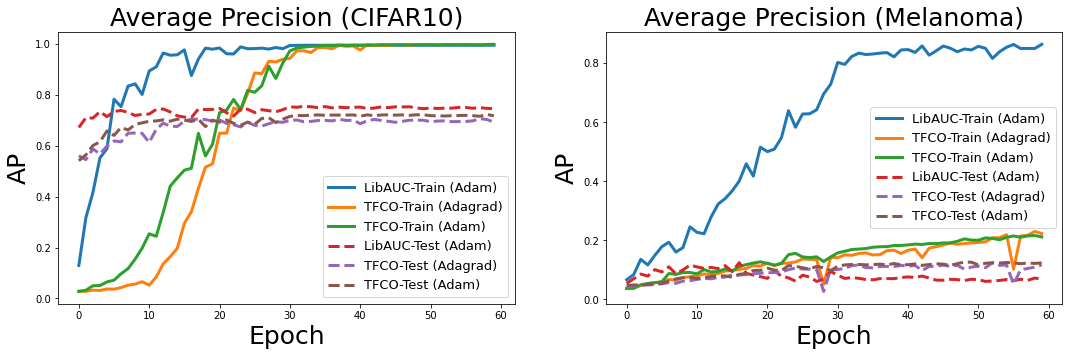

In [11]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18,5))
ax0.plot(train_list_c,linewidth=3, label='LibAUC-Train (Adam)')
ax0.plot(tfco_train_ada_c,linewidth=3, label='TFCO-Train (Adagrad)')
ax0.plot(tfco_train_adam_c,linewidth=3, label='TFCO-Train (Adam)')
ax0.plot(test_list_c, linestyle='dashed', linewidth=3, label='LibAUC-Test (Adam)')
ax0.plot(tfco_test_ada_c, linestyle='dashed', linewidth=3, label='TFCO-Test (Adagrad)')
ax0.plot(tfco_test_adam_c, linestyle='dashed', linewidth=3, label='TFCO-Test (Adam)')
ax0.set_title('Average Precision (CIFAR10)', fontsize=25)
ax0.set_xlabel('Epoch', fontsize=25)
ax0.set_ylabel('AP', fontsize=25)
ax0.legend(fontsize=13)

ax1.plot(train_list_m, linewidth=3, label='LibAUC-Train (Adam)')
ax1.plot(tfco_train_ada_m, linewidth=3, label='TFCO-Train (Adagrad)')
ax1.plot(tfco_train_adam_m, linewidth=3, label='TFCO-Train (Adam)')
ax1.plot(test_list_m, linestyle='dashed', linewidth=3, label='LibAUC-Test (Adam)')
ax1.plot(tfco_test_ada_m, linestyle='dashed', linewidth=3, label='TFCO-Test (Adagrad)')
ax1.plot(tfco_test_adam_m, linestyle='dashed', linewidth=3, label='TFCO-Test (Adam)')
ax1.set_title('Average Precision (Melanoma)', fontsize=25)
ax1.set_xlabel('Epoch', fontsize=25)
ax1.set_ylabel('AP', fontsize=25)
ax1.legend(fontsize=13)

plt.show()